In [1]:
import pandas as pd
import numpy as np 

def extractData(CSV_List):
    # Create an empty list to store the data
    timesteps = 75
    max_columns = 8
    inputs = np.empty((0, timesteps, max_columns))
    outputs = np.empty((0, 3))

    csv_list = CSV_List


    for dataSet in csv_list:
        data = pd.read_csv(dataSet)

        Time = data.iloc[:, 0].values
        Yaw_Input = data.iloc[:, 1].values  
        Yaw_Response = data.iloc[:, 2].values
        Motor1_Input = data.iloc[:, 3].values
        Motor2_Input = data.iloc[:, 4].values
        Pitch_Input = data.iloc[:, 5].values
        Pitch_Response = data.iloc[:, 6].values
        Motor1_Response = data.iloc[:, 7].values
        Motor2_Response = data.iloc[:, 8].values
        CG = data.iloc[:,9].values

        # Reset outputData for each dataset
        inputData = []
        outputData = []

        for i in range(timesteps, len(data)):
            timestep_inputs = np.transpose(np.array([Yaw_Input[i-timesteps:i], Yaw_Response[i-timesteps:i], Motor1_Input[i-timesteps:i], Motor2_Input[i-timesteps:i], Pitch_Input[i-timesteps:i], Pitch_Response[i-timesteps:i], Motor1_Response[i-timesteps:i], Motor2_Response[i-timesteps:i]]))
            inputData.append(timestep_inputs)
            if CG[i] == 0:
                outputData.append(np.array([0, 1, 0]))
    
            elif CG[i] == -1:
                outputData.append(np.array([1, 0, 0]))
    
            elif CG[i] == 1:
                outputData.append(np.array([0, 0, 1]))

        inputs = np.concatenate((inputs, inputData), axis=0)
        outputs = np.concatenate((outputs, outputData), axis=0)

    return inputs, outputs

In [2]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, GRU, BatchNormalization, Flatten, Dropout
from tensorflow.keras.optimizers import Adam
from Two_Load_Data import extractData

# List of CSV file paths
Data_Set_1 = '/home/coder/workspace/Goin/CategorizationNN2DOF/2DOF_0High_Hori_Data.csv' # Add your file paths here
Data_Set_2 = '/home/coder/workspace/Goin/CategorizationNN2DOF/2DOF_0High_Hori_Data2.csv'
Data_Set_3 = '/home/coder/workspace/Goin/CategorizationNN2DOF/2DOF_1High_Vert_Data.csv'
Data_Set_4 = '/home/coder/workspace/Goin/CategorizationNN2DOF/2DOF_Balanced_Data1.csv'
Data_Set_5 = '/home/coder/workspace/Goin/CategorizationNN2DOF/2DOF_Balanced_Data2.csv'
csv_list = [Data_Set_5, Data_Set_2, Data_Set_3, Data_Set_4, Data_Set_2]  


# # Define the neural network model
model = Sequential([
    LSTM(units=75, activation='tanh'),
    #Dense(units=100, activation='relu'),
   #Dense(units=90, activation='relu'),
    Dense(units=40, activation='tanh'),
    Dense(units=3, activation='softmax')  
])


# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

inputs, outputs = extractData(csv_list)
model.fit(inputs, outputs, epochs=150, batch_size=500)

# Save the model
model.save('2DOF-CGL1.h5')

: 

686/686 [==============================] - 2s 3ms/step


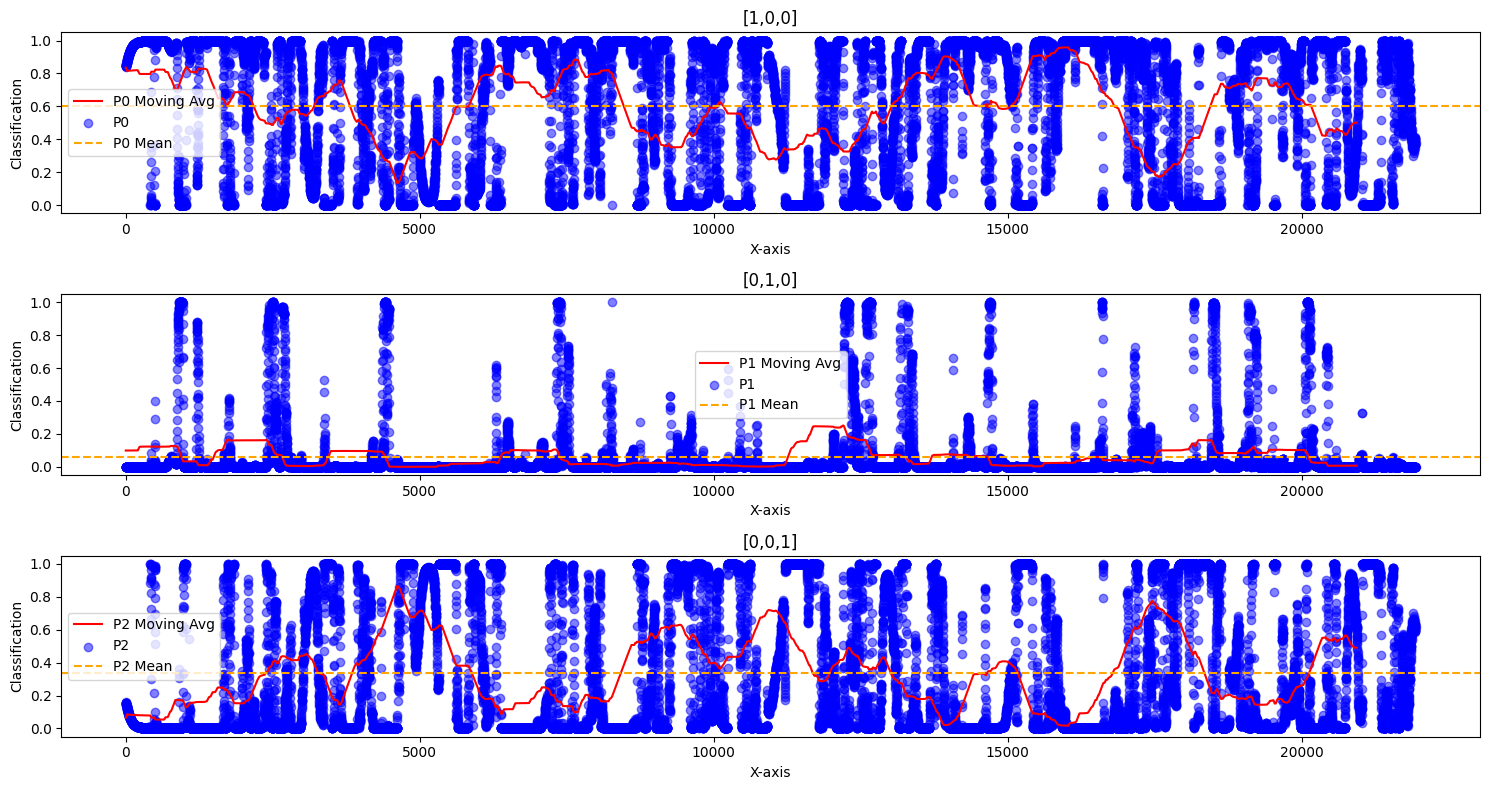

In [6]:
import matplotlib.pyplot as plt
from keras.models import load_model
from Two_Load_Data import extractData

model = load_model('2DOF-CGL1.h5')
readfile = ['/home/coder/workspace/Goin/CategorizationNN2DOF/2DOF_0High_Hori_Data.csv']

inputs, outputs = extractData(readfile)
predicted = model.predict(inputs)

# Plotting the data
P0, P1, P2 = [], [], []
x = range(len(outputs))
for r in x:
    P0.append(predicted[r, 0])
    P1.append(predicted[r, 1])
    P2.append(predicted[r, 2])

P0_mean = np.mean(P0)
P1_mean = np.mean(P1)
P2_mean = np.mean(P2)

# Calculate moving averages
window_size = 1000  # You can adjust the window size as needed
P0_avg = np.convolve(P0, np.ones(window_size) / window_size, mode='valid')
P1_avg = np.convolve(P1, np.ones(window_size) / window_size, mode='valid')
P2_avg = np.convolve(P2, np.ones(window_size) / window_size, mode='valid')

fig, axes = plt.subplots(3, 1, figsize=(15, 8))

# Plot the first subplot with moving average
axes[0].plot(x[:len(P0_avg)], P0_avg, color='red', label="P0 Moving Avg")
axes[0].scatter(x, P0, color='blue', marker='o', alpha=0.5, label="P0")
axes[0].axhline(y=P0_mean, color='orange', linestyle='--', label="P0 Mean")
axes[0].set_xlabel("X-axis")
axes[0].set_ylabel("Classification")
axes[0].set_title("[1,0,0]")
axes[0].legend()

# Plot the second subplot with moving average
axes[1].plot(x[:len(P1_avg)], P1_avg, color='red', label="P1 Moving Avg")
axes[1].scatter(x, P1, color='blue', marker='o', alpha=0.5, label="P1")
axes[1].axhline(y=P1_mean, color='orange', linestyle='--', label="P1 Mean")
axes[1].set_xlabel("X-axis")
axes[1].set_ylabel("Classification")
axes[1].set_title("[0,1,0]")
axes[1].legend()

# Plot the third subplot with moving average
axes[2].plot(x[:len(P2_avg)], P2_avg, color='red', label="P2 Moving Avg")
axes[2].scatter(x, P2, color='blue', marker='o', alpha=0.5, label="P2")
axes[2].axhline(y=P2_mean, color='orange', linestyle='--', label="P2 Mean")
axes[2].set_xlabel("X-axis")
axes[2].set_ylabel("Classification")
axes[2].set_title("[0,0,1]")
axes[2].legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Adding labels and title
plt.savefig("/home/coder/workspace/Goin/CategorizationNN2DOF/2DOFPredict.png") #this is super important on this system or else you won't be able to see plots
plt.show()